Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import (
    f1_score, accuracy_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, roc_curve, auc
)


Data loading

In [2]:
df = pd.read_csv('Heart_disease_cleveland_new.csv', encoding='utf-8-sig')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


Data exploration


In [3]:
print('--- Data Info ---')
df.info()
print('\n--- Missing Values ---')
print(df.isnull().sum())
print("--- Duplicate Rows ---")
print(df.duplicated().sum())


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB

--- Missing Values ---
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal     

In [4]:
print("\n--- Categorical Features ---")
expected_values = {
       'sex': [0, 1],
       'cp': [0, 1, 2, 3],
       'fbs': [0, 1],
       'restecg': [0, 1, 2],
       'exang': [0, 1],
       'slope': [0, 1, 2],
       'ca': [0, 1, 2, 3, 4],
       'thal': [1, 2, 3],
       'target': [0, 1]
   }

for feature, expected in expected_values.items():
       if feature in df.columns:
           unique_vals = sorted(df[feature].unique())
           print(f"{feature}: unique values in data = {unique_vals}, expected = {expected}")
           if set(unique_vals) != set(expected):
               print(f"  WARNING: Unexpected value(s) in {feature}!\n")
       else:
           print(f"{feature}: NOT FOUND in DataFrame columns!\n")
print('\n--- Basic Statistics ---')
display(df.describe(include='all'))


--- Categorical Features ---
sex: unique values in data = [np.int64(0), np.int64(1)], expected = [0, 1]
cp: unique values in data = [np.int64(0), np.int64(1), np.int64(2), np.int64(3)], expected = [0, 1, 2, 3]
fbs: unique values in data = [np.int64(0), np.int64(1)], expected = [0, 1]
restecg: unique values in data = [np.int64(0), np.int64(1), np.int64(2)], expected = [0, 1, 2]
exang: unique values in data = [np.int64(0), np.int64(1)], expected = [0, 1]
slope: unique values in data = [np.int64(0), np.int64(1), np.int64(2)], expected = [0, 1, 2]
ca: unique values in data = [np.int64(0), np.int64(1), np.int64(2), np.int64(3)], expected = [0, 1, 2, 3, 4]

thal: unique values in data = [np.int64(1), np.int64(2), np.int64(3)], expected = [1, 2, 3]
target: unique values in data = [np.int64(0), np.int64(1)], expected = [0, 1]

--- Basic Statistics ---


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,2.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,0.600660,0.663366,1.831683,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,0.956705,0.499120
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,1.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000


Separate features and target, Identify categorical and numeric features, Split data

In [5]:
# 
X = df.drop('target', axis=1)
y = df['target']

# Identify categorical and numeric features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numeric_features = [col for col in X.columns if col not in categorical_features]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 242 samples
Test set size: 61 samples


Preprocessing pipeline

In [6]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Logistic Regression

In [7]:
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42))
])
param_grid_logreg = [
    {
        'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'logreg__penalty': ['l2'],
        'logreg__solver': ['lbfgs', 'saga', 'newton-cg']
    },
    {
        'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'logreg__penalty': ['l1'],
        'logreg__solver': ['saga']
    },
    {
        'logreg__penalty': [None],
        'logreg__solver': ['lbfgs', 'saga', 'newton-cg']
    }
]
grid_logreg = GridSearchCV(pipe_logreg, param_grid_logreg, scoring='f1', cv=skf, n_jobs=-1)
grid_logreg.fit(X_train, y_train)
print('Best Logistic Regression params:', grid_logreg.best_params_)
print('Best F1-score (LogReg):', grid_logreg.best_score_)

Best Logistic Regression params: {'logreg__C': 1, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best F1-score (LogReg): 0.8383428360257629


Random Forest 

In [8]:
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])
param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 9, 10],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, scoring='f1', cv=skf, n_jobs=-1)
grid_rf.fit(X_train, y_train)
print('Best Random Forest params:', grid_rf.best_params_)
print('Best F1-score (RF):', grid_rf.best_score_)

Best Random Forest params: {'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best F1-score (RF): 0.8011351321001374


SVM 

In [9]:
pipe_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('svm', SVC(class_weight='balanced', probability=True, random_state=42))
])
param_grid_svm = {
    'svm__C': [0.01, 4, 5, 10, 100, 1000],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]
}
grid_svm = GridSearchCV(pipe_svm, param_grid_svm, scoring='f1', cv=skf, n_jobs=-1)
grid_svm.fit(X_train, y_train)
print('Best SVM params:', grid_svm.best_params_)
print('Best F1-score (SVM):', grid_svm.best_score_)

Best SVM params: {'svm__C': 5, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best F1-score (SVM): 0.8291417411861446


Evaluate best models on the test set


LogReg Test Results:
F1-score: 0.847457627118644
Accuracy: 0.8524590163934426
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86        33
           1       0.81      0.89      0.85        28

    accuracy                           0.85        61
   macro avg       0.85      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



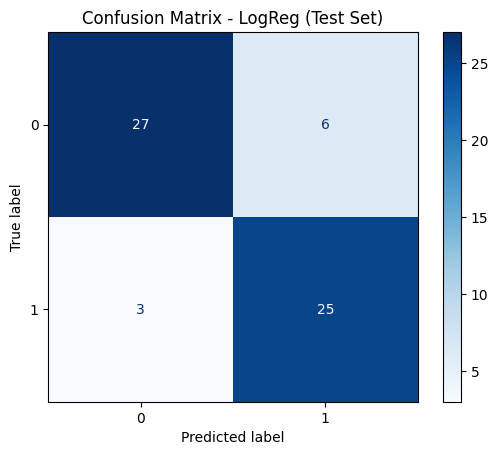


Random Forest Test Results:
F1-score: 0.8813559322033898
Accuracy: 0.8852459016393442
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



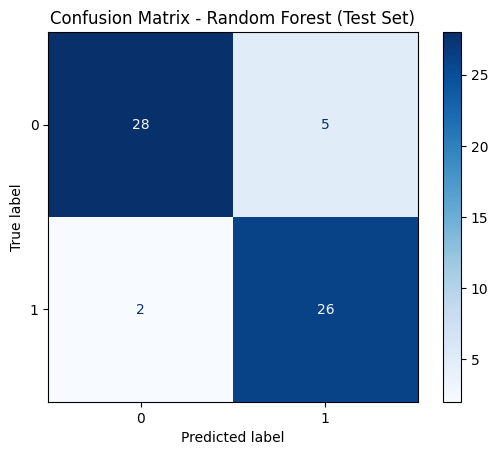


SVM Test Results:
F1-score: 0.8524590163934426
Accuracy: 0.8524590163934426
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.79      0.85        33
           1       0.79      0.93      0.85        28

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



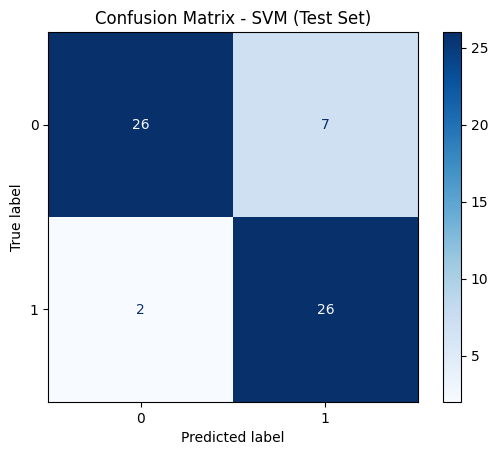

In [10]:
for name, model in [('LogReg', grid_logreg), ('Random Forest', grid_rf), ('SVM', grid_svm)]:
    y_pred = model.best_estimator_.predict(X_test)
    print(f"\n{name} Test Results:")
    print("F1-score:", f1_score(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.best_estimator_.named_steps[list(model.best_estimator_.named_steps.keys())[-1]].classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name} (Test Set)")
    plt.show()

ROC Curves for All Models

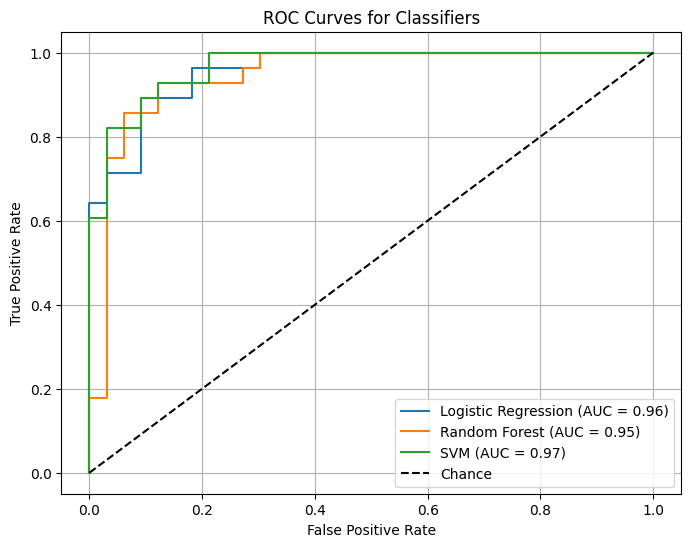

In [11]:
plt.figure(figsize=(8, 6))

y_score_logreg = grid_logreg.best_estimator_.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_score_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')

y_score_rf = grid_rf.best_estimator_.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

if hasattr(grid_svm.best_estimator_, "predict_proba"):
    y_score_svm = grid_svm.best_estimator_.predict_proba(X_test)[:, 1]
else:
    y_score_svm = grid_svm.best_estimator_.decision_function(X_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classifiers')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

PCA + Logistic Regression Pipeline

Best parameters (PCA pipeline): {'logreg__C': 4, 'logreg__penalty': 'l1', 'logreg__solver': 'saga', 'pca__n_components': 0.99}
Best cross-validated F1-score (PCA pipeline): 0.837
Test F1-score (LogReg + PCA pipeline): 0.862
Test Accuracy (LogReg + PCA pipeline): 0.869

Classification Report (LogReg + PCA pipeline):
               precision    recall  f1-score   support

           0       0.90      0.85      0.88        33
           1       0.83      0.89      0.86        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



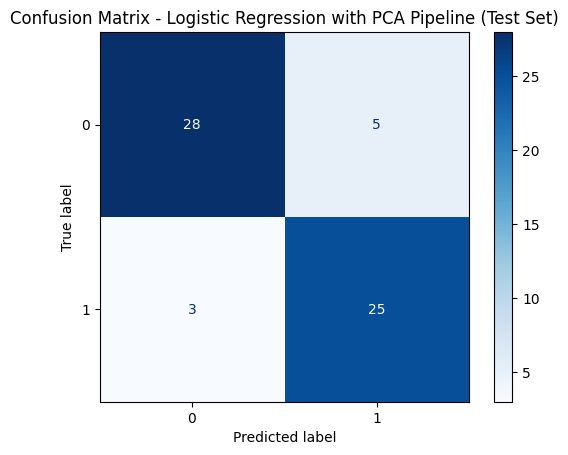

In [14]:
pipe_pca = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(random_state=42)),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

param_grid_pca = [
    {
        'pca__n_components': [0.90, 0.95, 0.99],
        'logreg__C': [0.001, 0.01, 0.1, 4, 10, 100, 1000],
        'logreg__penalty': ['l2'],
        'logreg__solver': ['lbfgs', 'saga', 'newton-cg']
    },
    {
        'pca__n_components': [0.90, 0.95, 0.99],
        'logreg__C': [0.001, 0.01, 1, 4, 100, 1000],
        'logreg__penalty': ['l1'],
        'logreg__solver': ['saga']
    },
    {
        'pca__n_components': [0.90, 0.95, 0.99],
        'logreg__penalty': [None],
        'logreg__solver': ['lbfgs', 'saga', 'newton-cg']
    }
]

grid_search_pca = GridSearchCV(
    estimator=pipe_pca,
    param_grid=param_grid_pca,
    scoring='f1',
    cv=skf,
    n_jobs=-1
)

grid_search_pca.fit(X_train, y_train)

print("Best parameters (PCA pipeline):", grid_search_pca.best_params_)
print("Best cross-validated F1-score (PCA pipeline): {:.3f}".format(grid_search_pca.best_score_))

best_pca_pipe = grid_search_pca.best_estimator_

y_pred_pca_pipe = best_pca_pipe.predict(X_test)

f1_pca_pipe = f1_score(y_test, y_pred_pca_pipe)
accuracy_pca_pipe = accuracy_score(y_test, y_pred_pca_pipe)
cm_pca_pipe = confusion_matrix(y_test, y_pred_pca_pipe)

print(f"Test F1-score (LogReg + PCA pipeline): {f1_pca_pipe:.3f}")
print(f"Test Accuracy (LogReg + PCA pipeline): {accuracy_pca_pipe:.3f}")
print("\nClassification Report (LogReg + PCA pipeline):\n", classification_report(y_test, y_pred_pca_pipe))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_pca_pipe, display_labels=best_pca_pipe.named_steps['logreg'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression with PCA Pipeline (Test Set)")
plt.show()

ROC Curve for PCA Pipeline

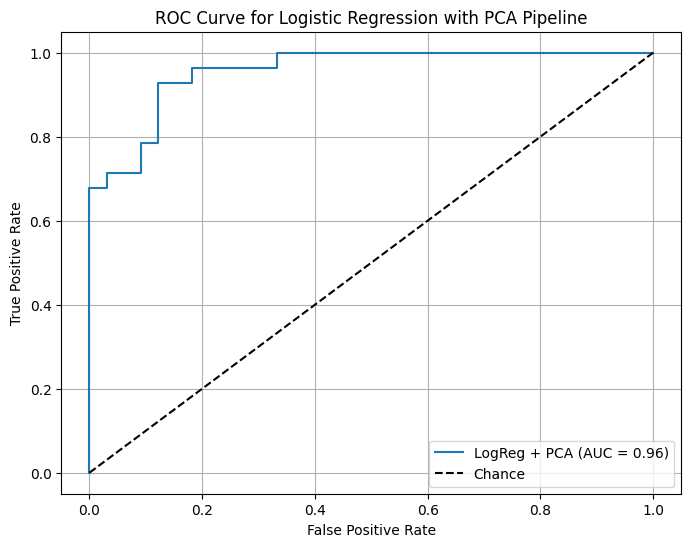

In [13]:
if hasattr(best_pca_pipe, "predict_proba"):
    y_scores_pca = best_pca_pipe.predict_proba(X_test)[:, 1]
else:
    y_scores_pca = best_pca_pipe.decision_function(X_test)
fpr_pca, tpr_pca, _ = roc_curve(y_test, y_scores_pca)
roc_auc_pca = auc(fpr_pca, tpr_pca)
plt.figure(figsize=(8, 6))
plt.plot(fpr_pca, tpr_pca, label=f'LogReg + PCA (AUC = {roc_auc_pca:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression with PCA Pipeline')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Explanation of choices:

I experimented with several supervised classification models: Logistic Regression, Random Forest, and Support Vector Machine (SVM). Each model was chosen for its unique strengths and suitability for different data characteristics.

Model Characteristics:

Logistic Regression is a strong baseline for binary classification, provides interpretable coefficients, and works well when the relationship between features and the target is (mostly) linear.
Random Forest is robust to outliers, can capture non-linear relationships, and is less sensitive to feature scaling and the presence of irrelevant features.
SVM is effective for high-dimensional data and can model complex decision boundaries, especially with the right kernel (linear or RBF).

Choice of Hyperparameters
Logistic Regression:

I tuned the regularization strength C over a wide range (0.001 to 1000), the penalty type (l1, l2, or no penalty), and the solver (lbfgs, saga, newton-cg) to balance underfitting and overfitting and to ensure compatibility with different penalties.

Random Forest:
I tuned n_estimators (number of trees), max_depth, min_samples_split, and min_samples_leaf to control model complexity, prevent overfitting, and optimize performance for the dataset size.

SVM:
I tuned C (regularization), kernel (linear and RBF), and gamma (for RBF) over a wide range of values to find the best margin and decision boundary for the data.
For all models, I used class_weight='balanced' to address class imbalance in the dataset.
Dimensionality Reduction (PCA)
To further analyze model performance, I also applied Principal Component Analysis (PCA) as a dimensionality reduction technique within a pipeline. I compared the results of Logistic Regression with and without PCA to see if reducing the number of features would improve accuracy or generalization.
PCA was integrated into the pipeline and tuned using cross-validation to ensure a fair and consistent comparison.

Model Selection
The best parameters for each model were selected based on cross-validated F1-score, which balances precision and recall and is especially important for imbalanced classification problems.

After evaluating the initial results with a broad set of primary hyperparameter values, I observed that the best performance was achieved with a value (e.g., C=10) that was at the edge or in the middle of the tested range. To ensure that this was truly optimal and not a local maximum, I refined the search by testing additional values around this point (such as C=4, 5, 6, 7, 8, 9, 11, 12, 13, etc.), allowing for a more precise identification of the best-performing hyperparameters.






The Heart Disease Cleveland dataset is moderately sized and slightly imbalanced, with a mix of numeric and categorical features. Because the target classes are not perfectly balanced, all models were trained with class_weight='balanced' to ensure that the minority class—patients with heart disease—received appropriate attention, improving recall and overall F1-score. For Logistic Regression, the best results were achieved with L1 regularization (penalty='l1'), the 'saga' solver, and a regularization strength of C=1. This configuration is particularly effective for data where some features may be irrelevant or redundant, as L1 regularization drives their coefficients to zero, effectively performing feature selection. The 'saga' solver is required for L1 and is efficient for high-dimensional data, while the moderate C value balances underfitting and overfitting. Random Forest achieved the highest F1-score and accuracy with 100 trees, a maximum depth of 10, and minimal constraints on splits and leaves. This setup allows the model to capture complex, non-linear relationships in the data while controlling for overfitting, which is important given the dataset’s size and feature diversity. The SVM performed best with a linear kernel and a higher regularization parameter (C=5), indicating that the data, after preprocessing and one-hot encoding, is well separated in the transformed feature space. The higher C value allows the model to fit the data more closely, and the use of class_weight='balanced' ensures sensitivity to the minority class. When applying PCA before Logistic Regression, the best results were achieved by retaining 99% of the variance (n_components=0.99) and using L1 regularization with C=4. PCA reduces dimensionality and noise, and L1 regularization further selects the most relevant principal components, helping generalization. 

The difference in model performance between retaining 99% and 95% of the variance with PCA was minimal, as both configurations preserved most of the informative signal in the data. However, when using pca__n_components=0.95, the best results were achieved with an L2 penalty (penalty='l2') and the 'lbfgs' solver. The L2 penalty is particularly suitable after PCA because, with dimensionality reduction, the remaining principal components are typically uncorrelated and all may contribute useful information. L2 regularization shrinks all coefficients but does not force any to zero, allowing the model to leverage the full set of principal components for prediction. The 'lbfgs' solver is efficient and robust for L2-regularized logistic regression, especially when the number of features is moderate, as is the case after PCA.